## Simulation for testing VarEM vs CausalVarEM + extraction methods for the treatment effect


In [1]:
from models.ICA_EM import *
from models.source_estimator import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [3]:
n = 10000
J = 6
I = J-1

In [4]:
# compare VarEM with CausalVarEM

treatmet_true = []
treatment_var_perm= []
treatment_causal_perm = []
score_var = []
score_causal = []
treatment_var_first_column = []
treatment_causal_first_column = []
mse_var = []
mse_causal = []
likelihood_score_var = []
likelihood_score_causal = []

data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)} ,noise_dict={"loc" : 0, "scale" : 0})

for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    estimator = VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i)
    estimator.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator.A)    
    score_var.append(score)
    treatment_var_perm.append(norm_funtion(estimator.A[:, best_perm])[1])
    treatment_var_first_column.append(norm_funtion(estimator.A)[1])
    mse_var.append(mean_squared_error(data.signals, estimator.Signals[:, best_perm]))
    likelihood_score_var.append(likelihood_score(data.signals, estimator.Signals[:, best_perm]))

    estimator_Causal = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "each")
    estimator_Causal.fit(data.data_observed, J = J, progress_bar=False)
    best_perm, score = f_score(data.mixing_matrix_observed, estimator_Causal.A)    
    score_causal.append(score)
    treatmet_true.append(data.treatment_effect)
    treatment_causal_perm.append(norm_funtion(estimator_Causal.A[:,best_perm])[1])
    treatment_causal_first_column.append(norm_funtion(estimator_Causal.A)[1])
    mse_causal.append(mean_squared_error(data.signals, estimator_Causal.Signals[:, best_perm]))
    likelihood_score_causal.append(likelihood_score(data.signals, estimator_Causal.Signals[:, best_perm]))


100%|██████████| 100/100 [2:30:37<00:00, 90.37s/it] 


In [5]:
# save results
results = pd.DataFrame({"treatment_true" : treatmet_true, 
                        "treatment_var_perm" : treatment_var_perm, 
                        "treatment_var_first_column" : treatment_var_first_column, 
                        "treatment_causal_perm" : treatment_causal_perm,
                          "treatment_causal_first_column" : treatment_causal_first_column,
                            "score_var" : score_var,
                              "score_causal" : score_causal,
                                "mse_var" : mse_var,
                                  "mse_causal" : mse_causal,
                                    "likelihood_score_var" : likelihood_score_var,
                                      "likelihood_score_causal" : likelihood_score_causal})
#results.to_csv("results/results_var_vs_causal_no_noise.csv", index = False)


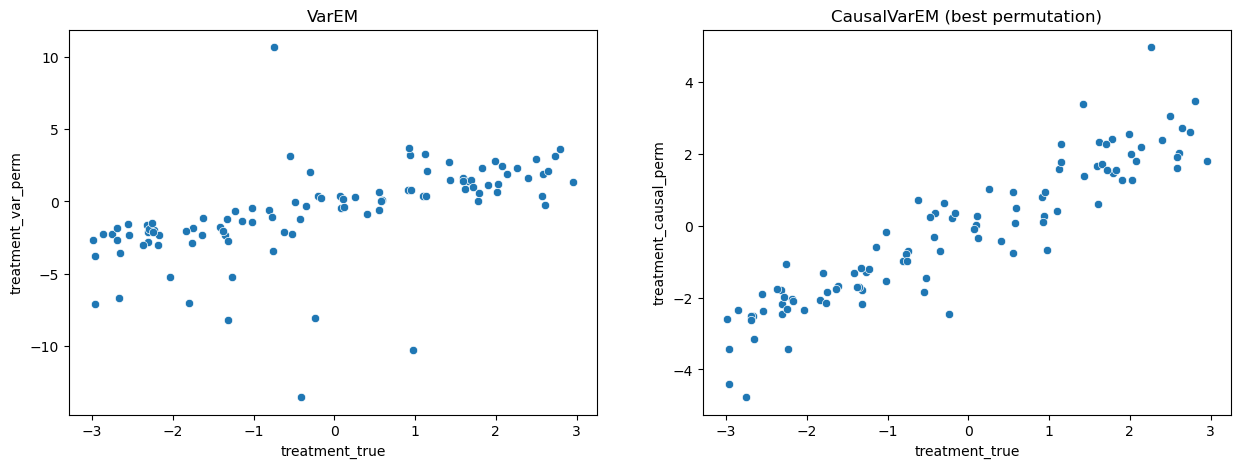

7.227191061599829
0.5471615414345423


In [4]:
results = pd.read_csv("results/results_var_vs_causal_no_noise.csv")
fig, ax = plt.subplots(1,2,figsize = (15,5)) 
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_perm, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax = ax[1])
ax[1].title.set_text('CausalVarEM (best permutation)')
plt.show()
print(mse(results.treatment_true, results.treatment_var_perm))
print(mse(results.treatment_true, results.treatment_causal_perm))

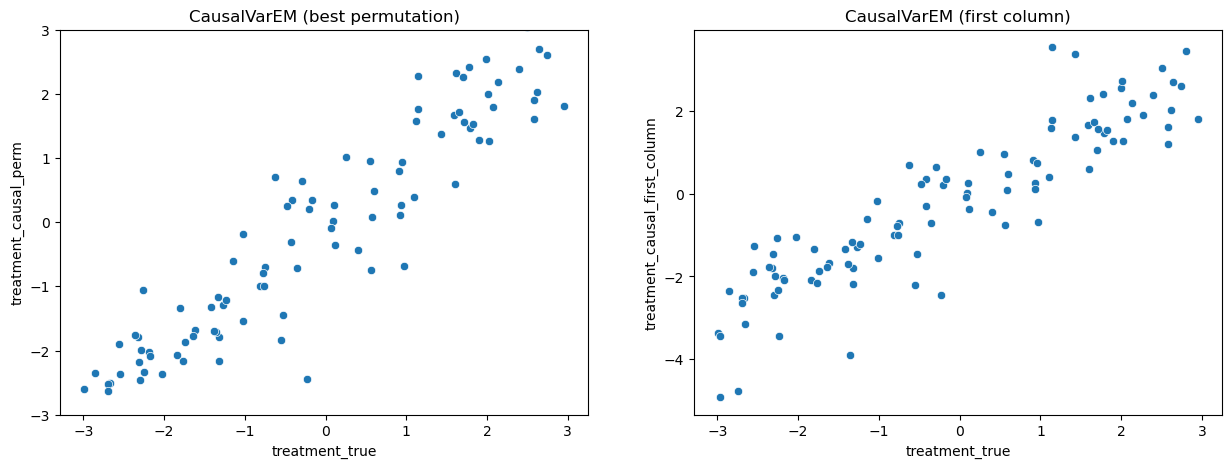

0.5471615414345423
0.6643886552786893


In [5]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax = ax[0])
ax[0].title.set_text('CausalVarEM (best permutation)')
ax[0].set_ylim(-3,3)
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM (first column)')
#ax[1].set_ylim(-3,3)y¥¥y
plt.show()  
print(mse(results.treatment_true, results.treatment_causal_perm))
print(mse(results.treatment_true, results.treatment_causal_first_column))


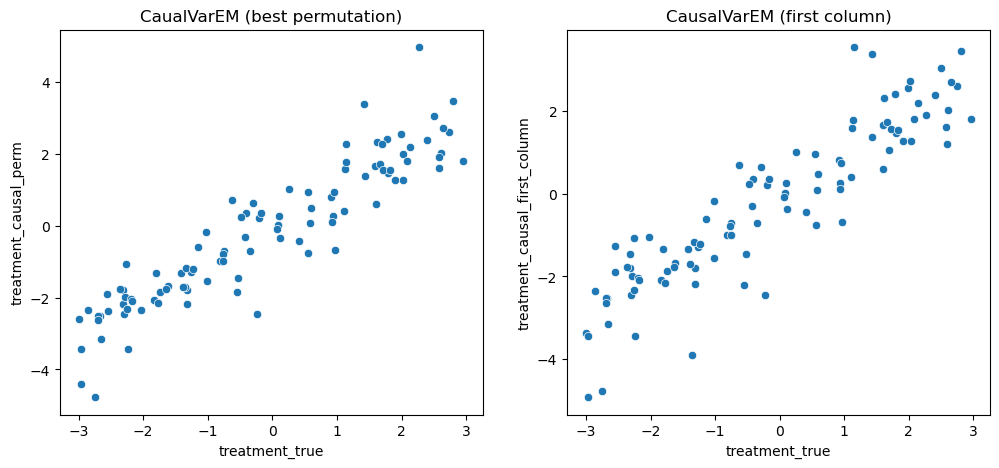

0.5471615414345423
0.6643886552786893
0.737955409171058
0.4747602448446546


In [6]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_causal_perm, ax=ax[0])
ax[0].title.set_text('CaualVarEM (best permutation)')
sns.scatterplot(x =results.treatment_true, y = results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM (first column)')  
plt.show()
print(mse(results.treatment_true, results.treatment_causal_perm))
print(mse(results.treatment_true, results.treatment_causal_first_column))
print(np.std(results.treatment_true - results.treatment_causal_perm))
print(np.std(results.treatment_causal_perm - results.treatment_causal_first_column))


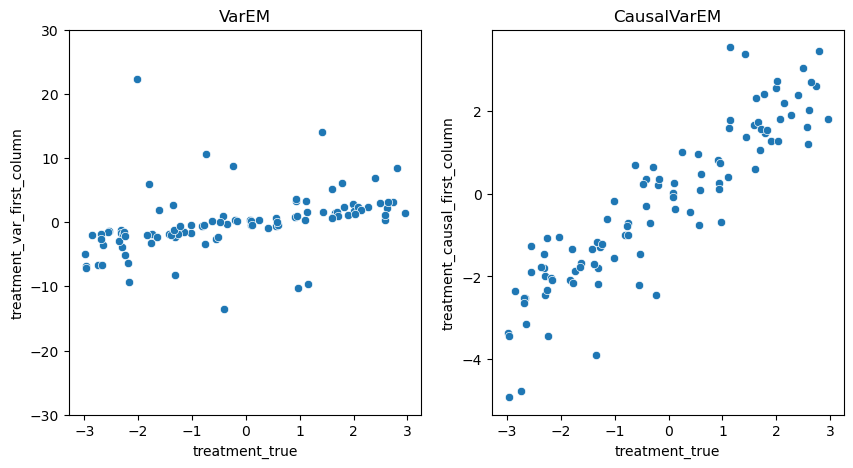

In [8]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.scatterplot(x=results.treatment_true, y=results.treatment_var_first_column, ax=ax[0])
ax[0].title.set_text('VarEM')
ax[0].set_ylim(-30,30)
sns.scatterplot(x =results.treatment_true, y = results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
plt.show()

In [9]:
print(np.mean(results, axis=0))

# std
print(np.std(results))


treatment_true                      -0.177828
treatment_var_perm                  -0.769362
treatment_var_first_column          33.241761
treatment_causal_perm               -0.228655
treatment_causal_first_column       -0.267448
score_var                            0.341871
score_causal                         0.164366
mse_var                              1.221892
mse_causal                           1.042095
likelihood_score_var            -18721.703824
likelihood_score_causal         -18463.537116
dtype: float64
treatment_true                      1.762762
treatment_var_perm                  3.187912
treatment_var_first_column        335.378264
treatment_causal_perm               1.929154
treatment_causal_first_column       1.911477
score_var                           0.206376
score_causal                        0.126604
mse_var                             0.184415
mse_causal                          0.148784
likelihood_score_var             1332.032073
likelihood_score_causal      

/Users/marvinlob/micromamba/envs/sem_pj/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


## Plot one example

In [24]:
# plot signals righltly ordered
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 0})
data.generate_data(n=n, J=J, I=I, random_state=2)
VarEM_est= VarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=1)
VarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})
CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= None, tol=1e-4, max_iter=200, random_seed=1, mode="each")
CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})



Initializing A with true A + noise


Diff: 0.0019: 100%|██████████| 200/200 [00:46<00:00,  4.26it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 77035.61it/s]


Initializing A randomly


Diff: 0.0746: 100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Estimating the signals


100%|██████████| 10000/10000 [00:00<00:00, 90735.92it/s]


0.621812081399002
0.03548394845917706


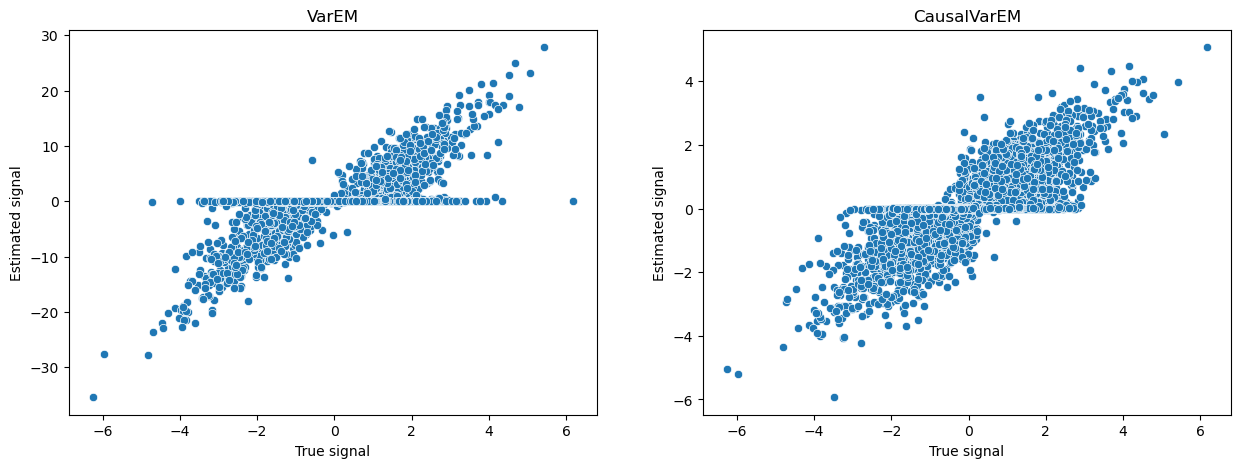

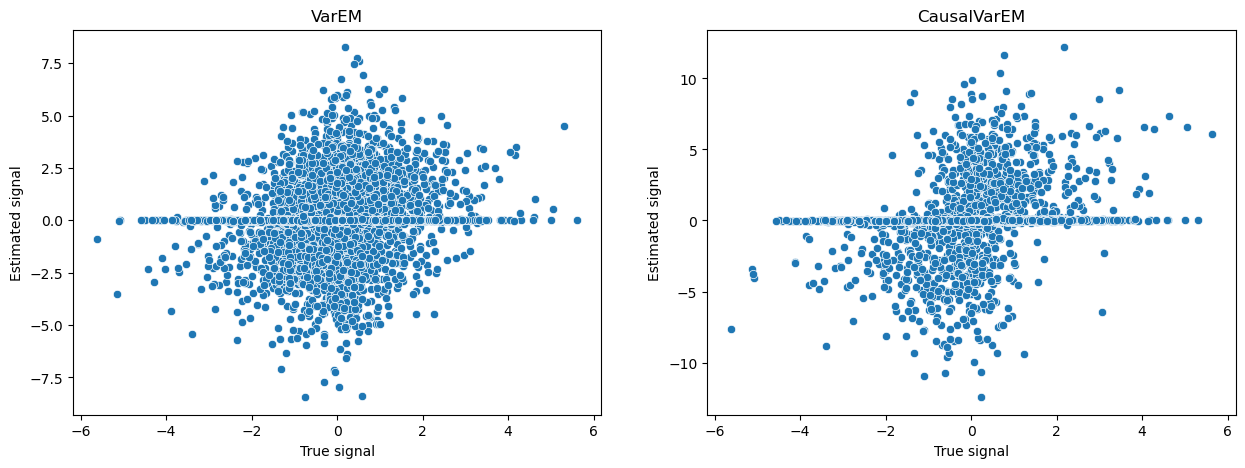

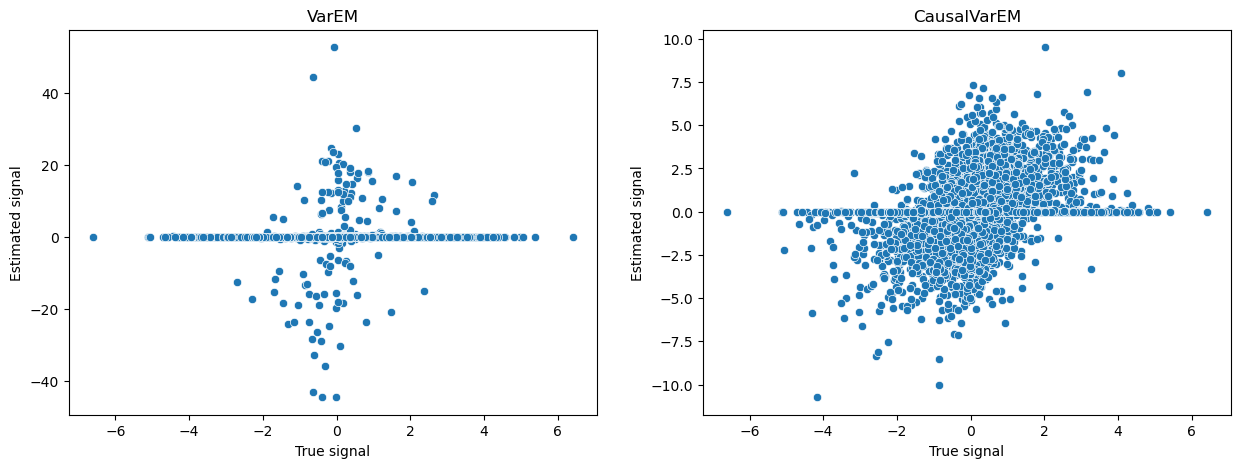

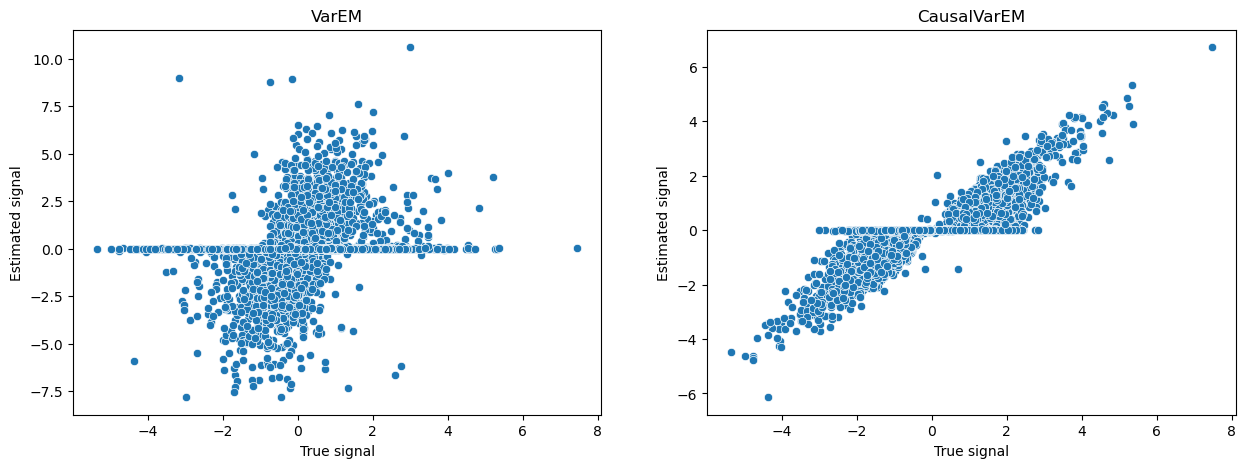

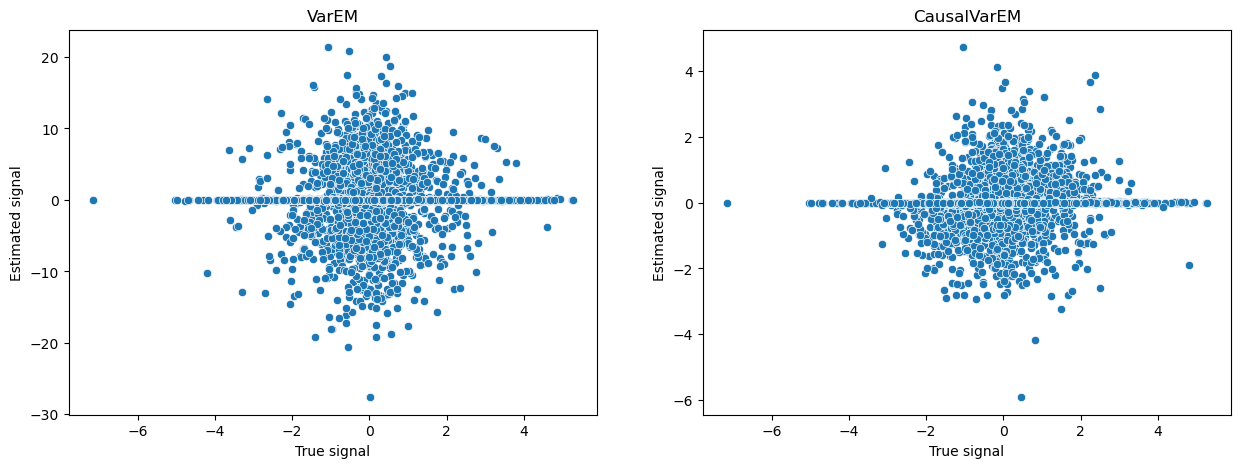

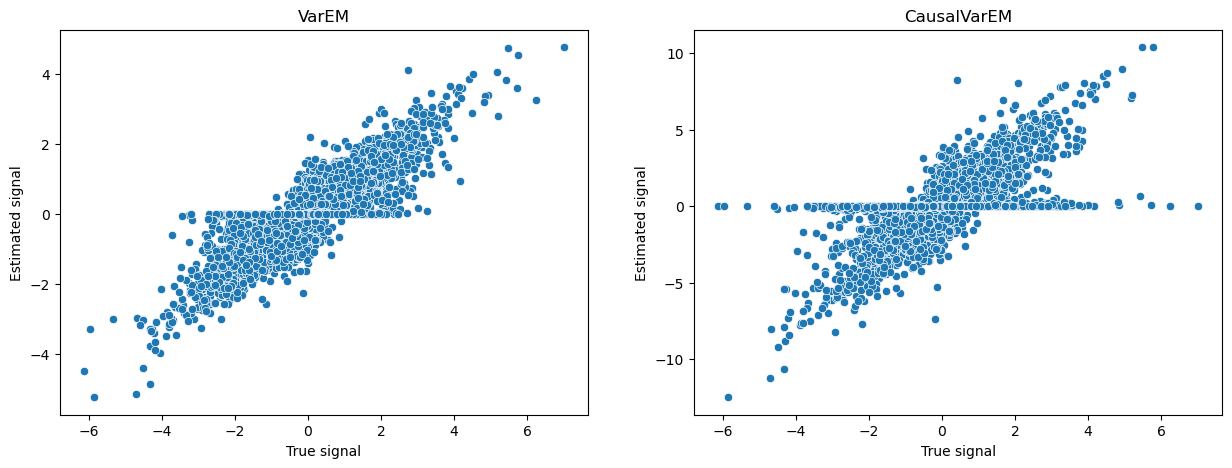

In [25]:
best_perm_var, score = f_score(data.mixing_matrix_observed, VarEM_est.A)
print(score)
singals_estimation_VAR = VarEM_est.Signals[:,best_perm_var]
best_perm_causal, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
print(score)
singals_estimation_Causal = CausalVarEM_est.Signals[:,best_perm_causal]
for i in range(J):
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_VAR[:,i], ax = ax[0])
    ax[0].title.set_text('VarEM')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_Causal[:,i], ax = ax[1])
    ax[1].title.set_text('CausalVarEM')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    plt.show()
    

### Test separate source estimator

In [26]:
source_est = SourceEstimator(noise= True)
source_est.fit(data.data_observed, CausalVarEM_est.A)

Fitting the model to the data in the noisy case


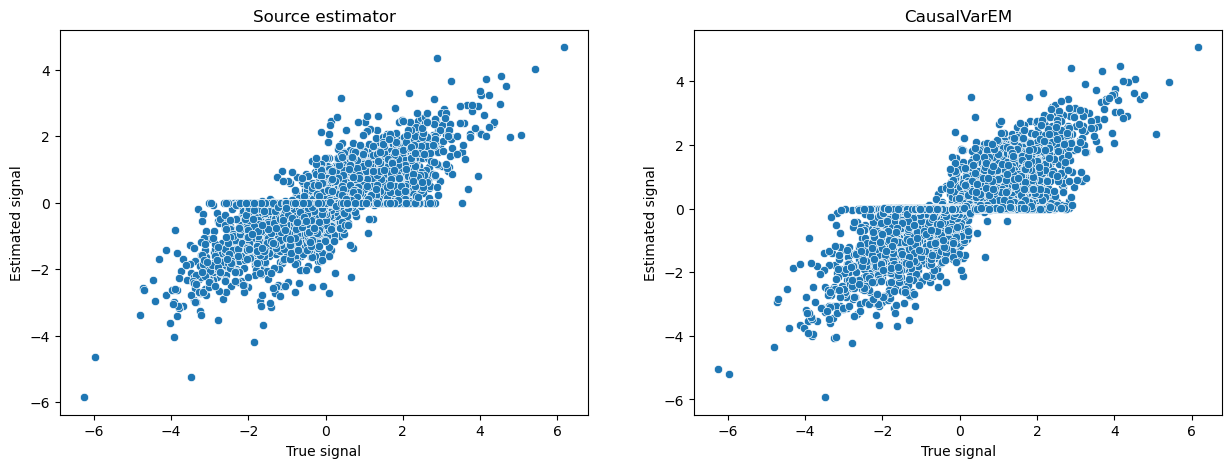

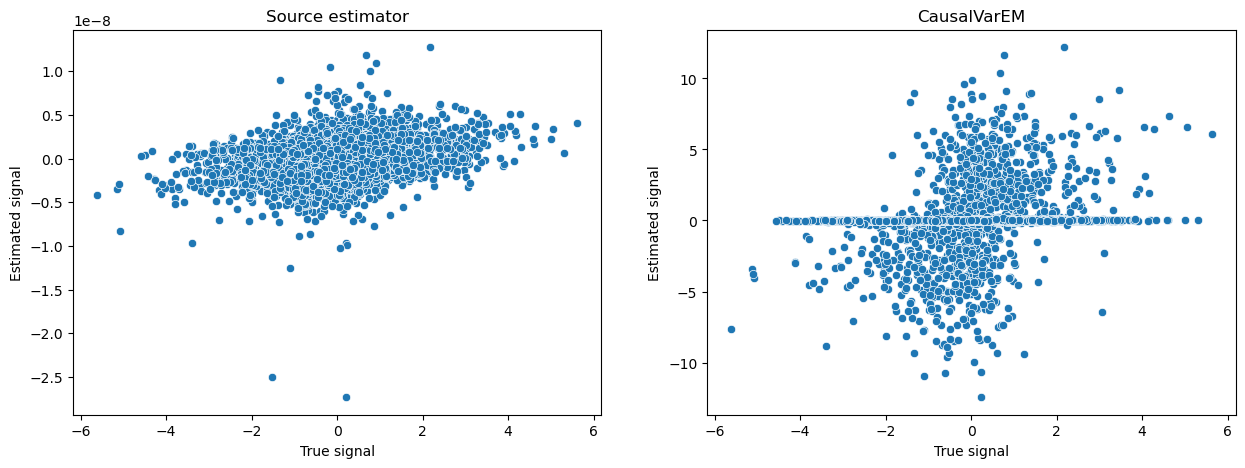

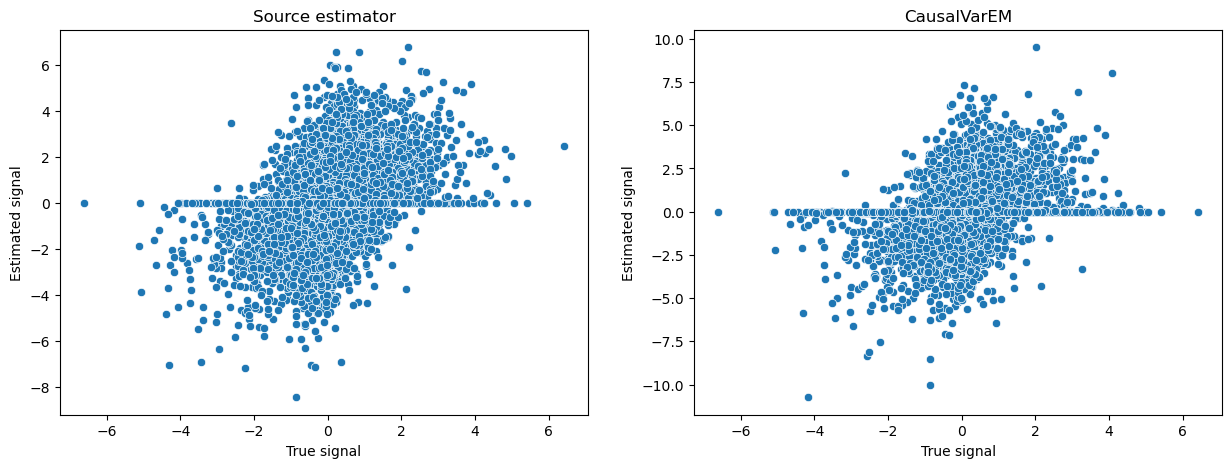

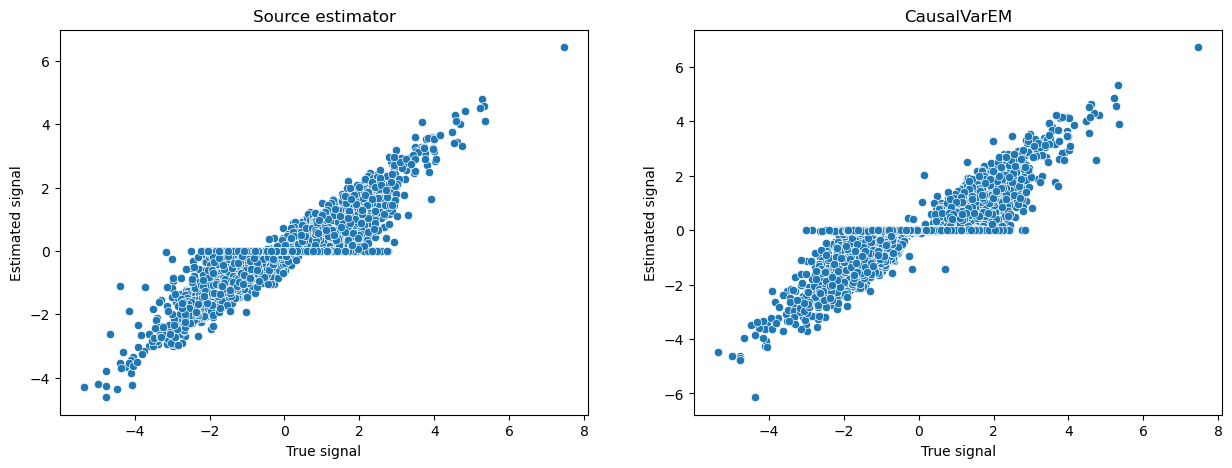

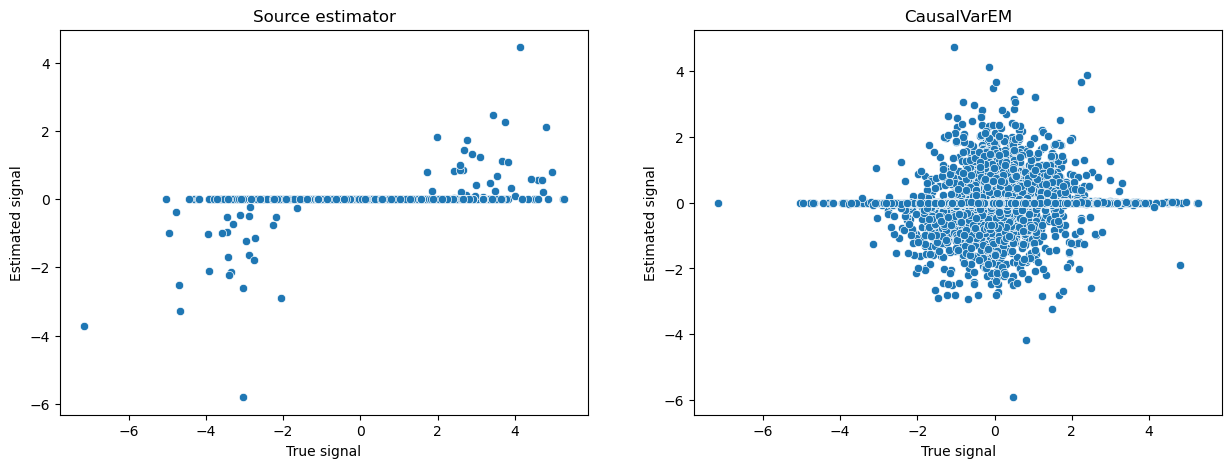

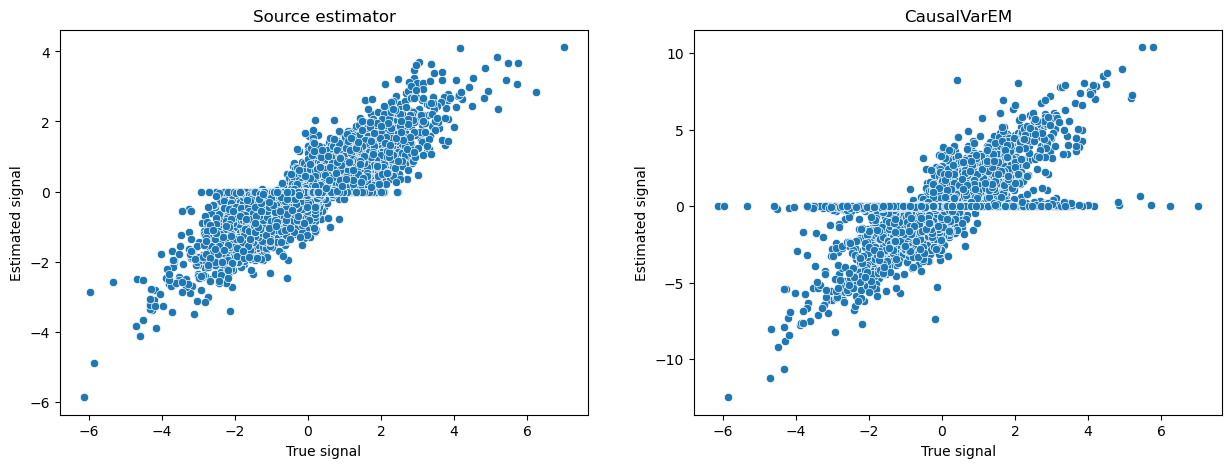

In [27]:
# plot 
for i in range(J):
    fig, ax = plt.subplots(1,2,figsize = (15,5))
    sns.scatterplot(x = data.signals[:,i], y = source_est.Signals[:,i], ax = ax[0])
    ax[0].title.set_text('Source estimator')
    ax[0].set_xlabel('True signal')
    ax[0].set_ylabel('Estimated signal')
    sns.scatterplot(x = data.signals[:,i], y = singals_estimation_Causal[:,i], ax = ax[1])
    ax[1].title.set_text('CausalVarEM')
    ax[1].set_xlabel('True signal')
    ax[1].set_ylabel('Estimated signal')
    plt.show()

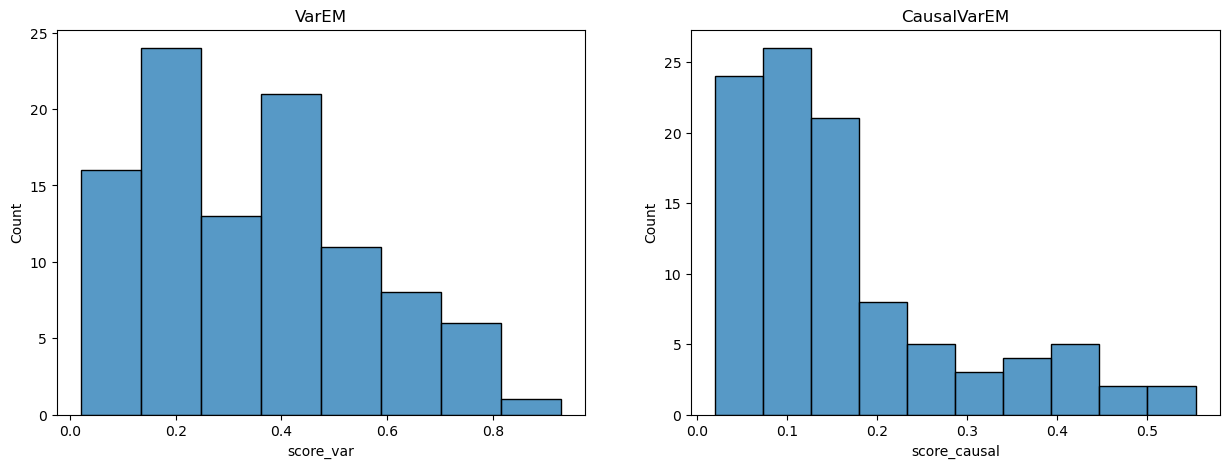

In [28]:
# plot scores
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.score_var, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.histplot(results.score_causal, ax = ax[1])
ax[1].title.set_text('CausalVarEM')


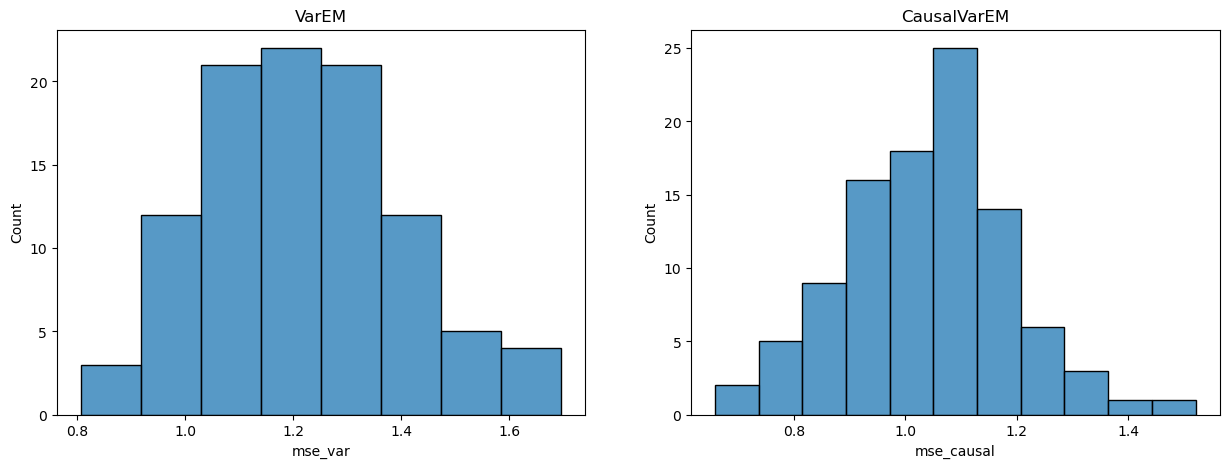

In [29]:
# plot mse
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.mse_var, ax = ax[0])
ax[0].title.set_text('VarEM')
sns.histplot(results.mse_causal, ax = ax[1])
ax[1].title.set_text('CausalVarEM')


(-10.0, 10.0)

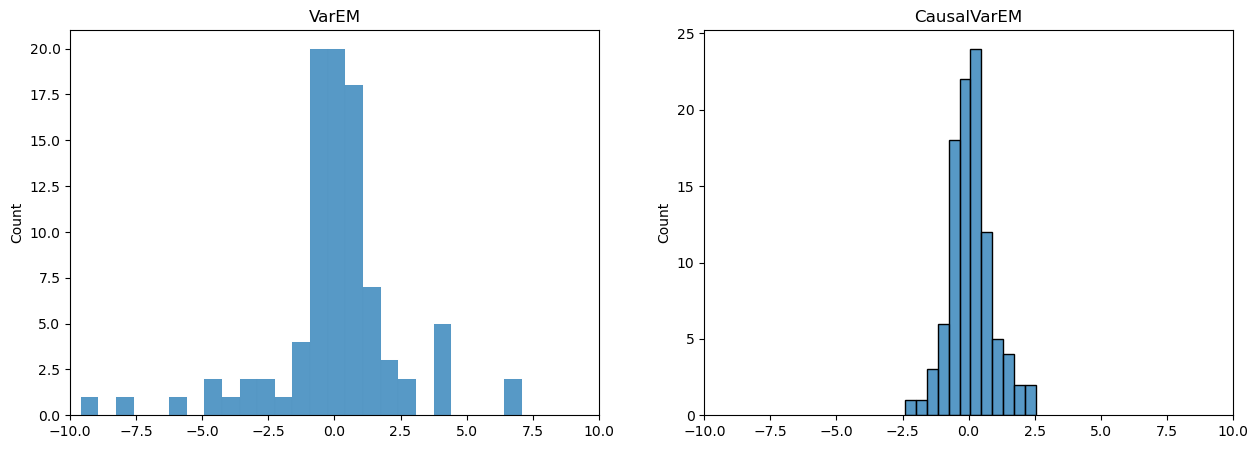

In [30]:
# plot difference between true and estimated treatment effect exclude outliers +-10
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.histplot(results.treatment_true - results.treatment_var_first_column, ax = ax[0])
ax[0].title.set_text('VarEM')
ax[0].set_xlim(-10,10)
sns.histplot(results.treatment_true - results.treatment_causal_first_column, ax = ax[1])
ax[1].title.set_text('CausalVarEM')
ax[1].set_xlim(-10,10)


